In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


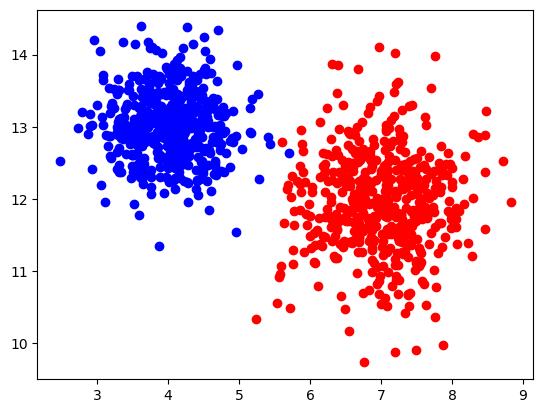

In [82]:
# сгенерируем два класса, которые можно разделить линейно. Назовем их blue и red.
blue_class_X = np.random.normal(4, 0.5, 500)
blue_class_Y = np.random.normal(13, 0.5, 500)
red_class_X = np.random.normal(7, 0.6, 500)
red_class_Y = np.random.normal(12, 0.7, 500)

plt.scatter(blue_class_X, blue_class_Y, c='blue')
plt.scatter(red_class_X, red_class_Y, c='red')

In [83]:
# объединим их и дадим классам метки. Будем предсказывать вероятность точке принадлежать синему классу. Обозначим целевую переменную синего класса как 1 
# и целевую переменную красного класса как 0
X1_combined = np.concatenate((blue_class_X, red_class_X))
X2_combined = np.concatenate((blue_class_Y, red_class_Y))
blue_class_target = np.ones(len(blue_class_X))
red_class_target = np.zeros(len(red_class_X))
Y = np.concatenate((blue_class_target, red_class_target))
X = np.matrix([X1_combined, X2_combined]).T

# перемешаем их одинаковым способом
p = np.random.permutation(len(Y))
X = X[p]
Y = Y[p]

print(X)
print(Y[:20])

[[ 7.60704007 12.19785168]
 [ 7.39990872 11.58960307]
 [ 6.87184517 11.56218983]
 ...
 [ 3.38168191 13.13203854]
 [ 7.03515332 11.89266169]
 [ 6.53917083 12.74665878]]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.]


In [84]:
# я не стал делить выборку на test и train, потому что все равно беру признаки выборки из нормального распределения. Потому просто сгенерируем test из норм. 
# распределения с такими же параметрами, как и train.
blue_test_X = np.random.normal(4, 0.5, 10_000)
blue_test_Y = np.random.normal(13, 0.5, 10_000)
red_test_X = np.random.normal(7, 0.6, 10_000)
red_test_Y = np.random.normal(12, 0.7, 10_000)

X1_combined_test = np.concatenate((blue_test_X, red_test_X))
X2_combined_test = np.concatenate((blue_test_Y, red_test_Y))

blue_test_target = np.ones(len(blue_test_X))
red_test_target = np.zeros(len(red_test_X))

Y_test = np.concatenate((blue_test_target, red_test_target))
X_test = np.matrix([X1_combined_test, X2_combined_test]).T

p = np.random.permutation(len(Y_test))
X_test = X_test[p]
Y_test = Y_test[p]


# Логистическая регрессия

Конечным результатом задачи классификации является разбиение множества объектов на классы. Давайте усложним задачу и будем предсказывать не конкретные классы, а вероятности принадлежать им, например, для бинарной классификации мы будем предсказывать одно число, которое будет соответствовать вероятности принадлежать положительному классу. \
Такого результата можно достичь, если мы будем строить линейную регрессию над некоторыми признаками, а затем её результат переводить в отрезок $[0;1]$. В этом нам поможет сигмоидная функция, которая имеет вид:
$f(z) = \dfrac{1}{1 + e^{-z}}$

![sigmoid.webp](https://cmertin.github.io/images/2016/11/11_17-Loan_Approvals/Sigmoid_Function.png)
<p style="text-align: center;"></p>

Моделью логистической регрессии назовём функцию от весов и объекта вида:

$a(w, x) = \dfrac{1}{1 + e^{-w_0 - w_1x_1 + ... + w_mx_m}}$

Обучение данной модели происходит за счет кросс-энтропийной или логистическая функции потерь :
$-\dfrac{1}{N}\sum\limits_{i=1}^{n}(y_iln(a_i) + (1 - y_i)ln(1 - a_i))$
где $a_i = a(w, x_i)$

#### Задание №1. Выведите шаг градиентного спуска для логистической функции потерь (приложить фото)

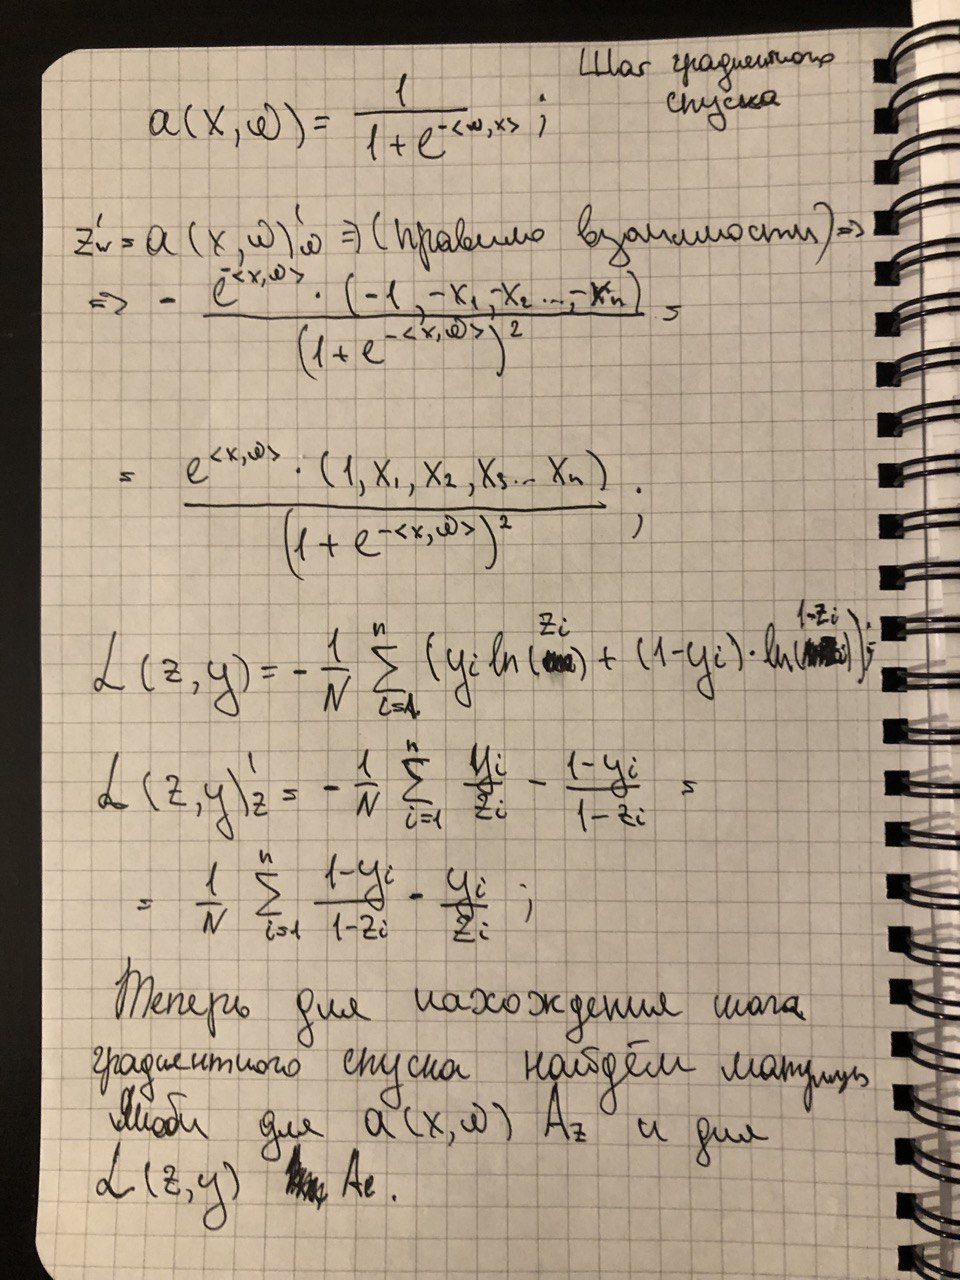

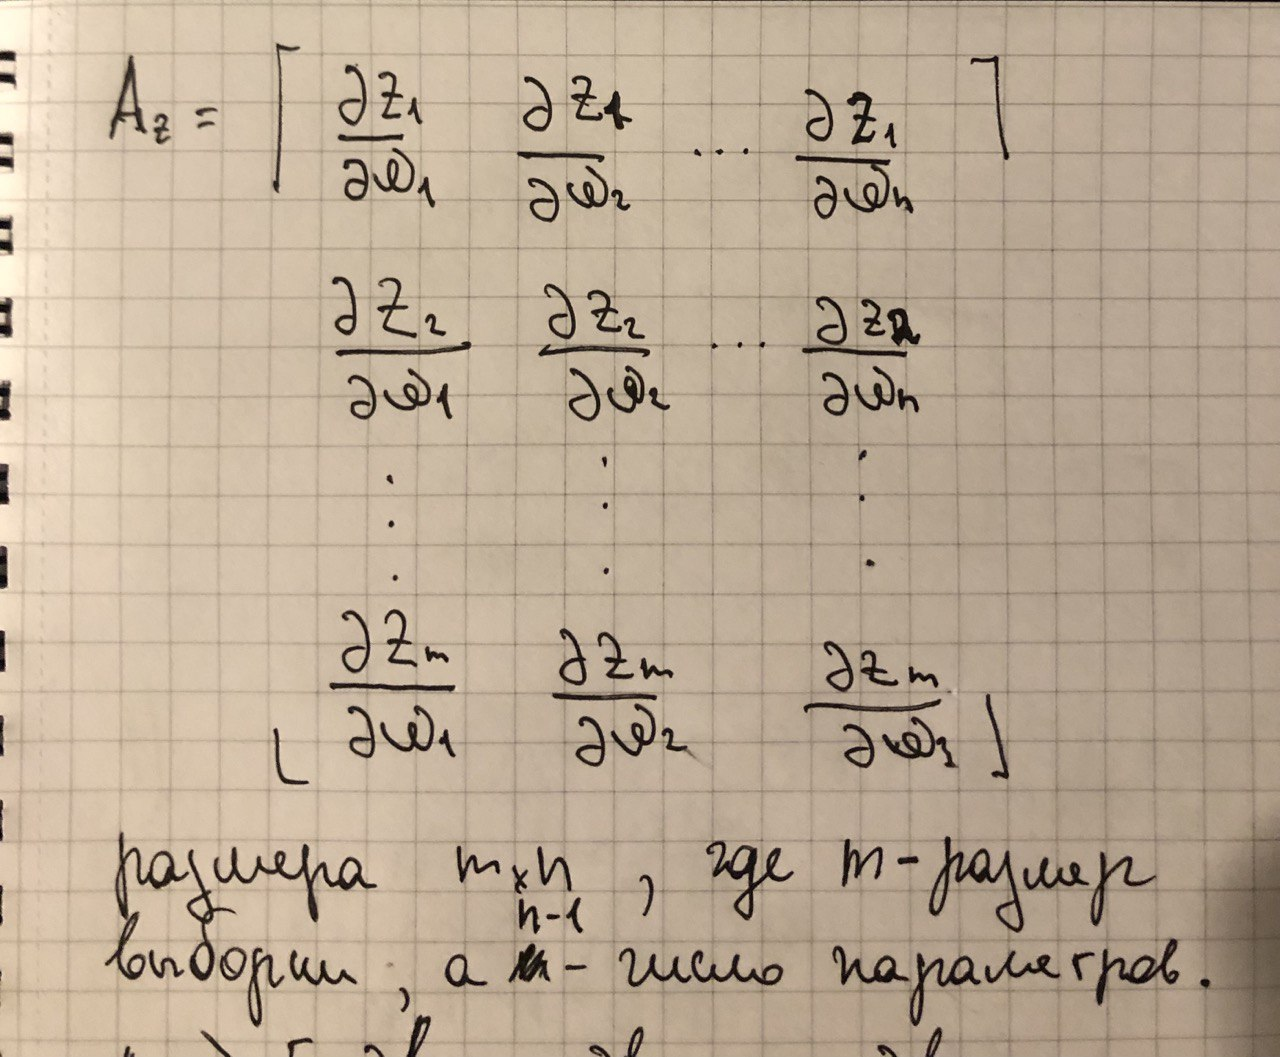

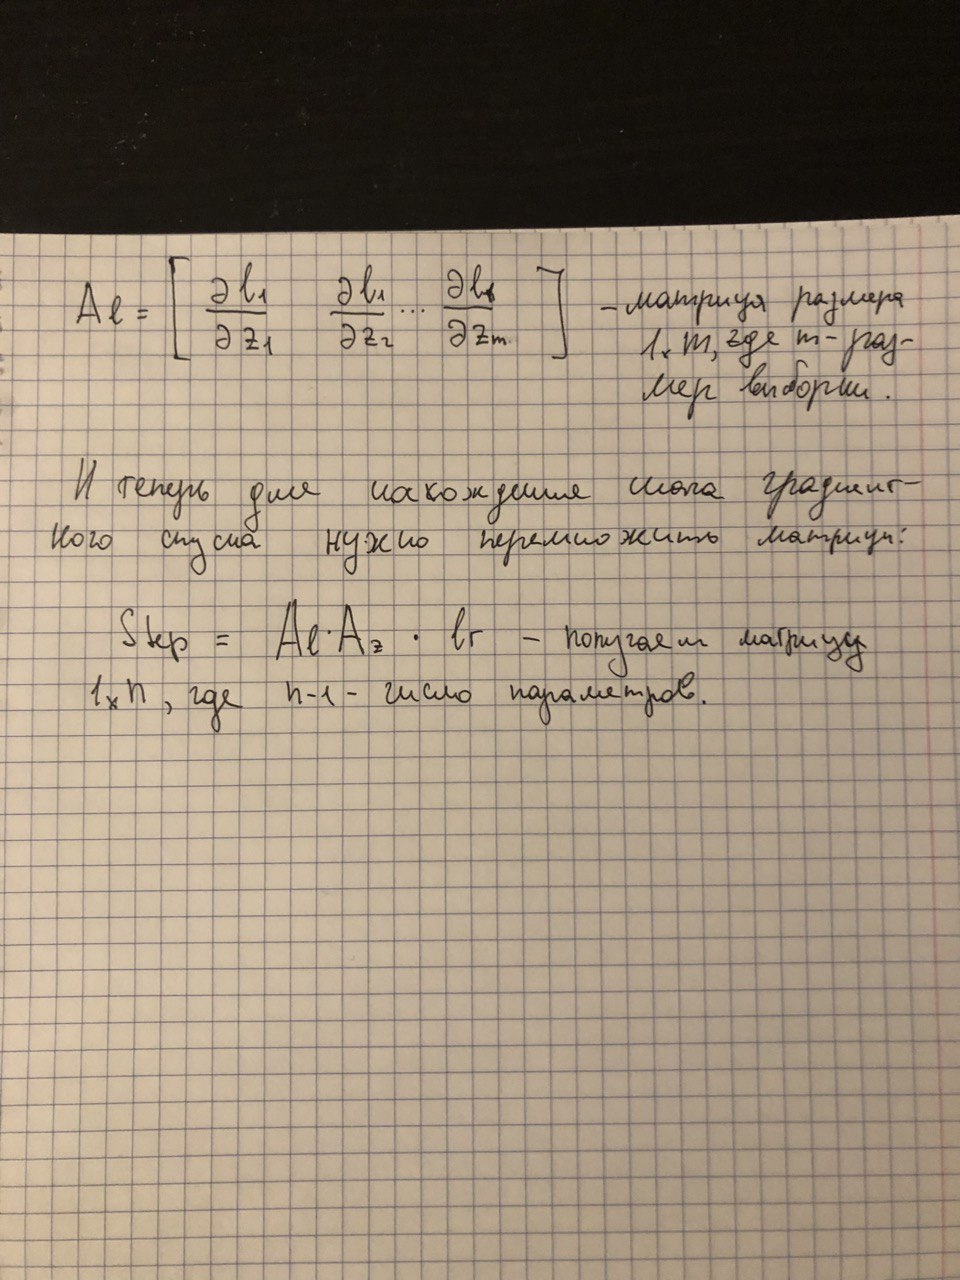

#### Задание №2. Напишите собственную логистическую регрессию

In [102]:
class MyLogRegression():

    def __init__(self, X, Y, omega, lr = 0.1, fit_iterations = 10_000):
        self.X = X
        self.Y = Y
        self.init_omega = omega
        self.lr = lr
        self.fit_iterations = fit_iterations
    
    def a(self, X, omega):
        Z = []
        for row in X:
            x_omega_mult = omega[0] + np.sum(np.multiply(row, omega[1:]))
            current_res = 1 / (1 + np.exp(-x_omega_mult))
            Z.append(current_res)
        return np.matrix(Z)

    def loss_jacobi(self, Z, Y):
        Z = Z.A1
        assert len(Z) == len(Y)
        jacobi_matrix = ((1 - Y) / (1 - Z) - Y / Z) / len(Y)
        return np.matrix(jacobi_matrix)
    
    def a_jacobi(self, X, omega):
        jacobi_matrix = []
        for X_row in X:
            X_row = X_row.A1
            x_omega_mult = omega[0] + np.sum(np.multiply(X_row, omega[1:]))
            current_partial_deriatives = np.exp(-x_omega_mult) * np.insert(X_row, 0, 1) / ((1 + np.exp(-x_omega_mult)) ** 2)
            jacobi_matrix.append(current_partial_deriatives)
        return np.matrix(jacobi_matrix)
    
    def decicion_boundary_2params(self, vector_x):
        ln_component = (np.log(1 / self.threshold - 1) - self.trained_omega[0]) / self.trained_omega[2]
        x1_component = vector_x * self.trained_omega[1] / self.trained_omega[2]
        return ln_component - x1_component
    
    def step(self, X, Y, omega, lr):
        Z = self.a(X, omega)
        a_jacobi = self.a_jacobi(X, omega)
        loss_jacobi = self.loss_jacobi(Z, Y)
        grad = (loss_jacobi @ a_jacobi).A1
        return np.subtract(omega, lr * grad)

    def fit(self):
        current_omega = self.init_omega
        for i in range(self.fit_iterations):
            current_omega = self.step(self.X, self.Y, current_omega, self.lr)
        self.trained_omega = current_omega
        return self.trained_omega
    
    def predict(self, predict_X, threshold):
        self.threshold = threshold
        predicted_arr = self.predics_probability(predict_X)
        return np.where(predicted_arr >= threshold, 1, 0)
    
    def predics_probability(self, predict_X):
        return self.a(predict_X, self.trained_omega).A1
    


#### Задание №3. Сравните свою логистическую регрессию с аналогичной моделью из sklearn на сгенерированном датасете, опираясь на Accuracy. Баллы за задание: 10 - Accuracy > 99, 5 - Accuracy > 85, 0 - иначе

In [126]:
start_omega = np.array([0.1, 0.1, 0.1])
my_regression = MyLogRegression(X, Y, start_omega, 0.01, 10_000)
trained_omega = my_regression.fit()
print(trained_omega)

[ 0.12882623 -3.56726636  1.54080793]


In [127]:
my_predictions = my_regression.predict(X_test, 0.5)

my_score = accuracy_score(Y_test, my_predictions)
print(my_score)

0.99705


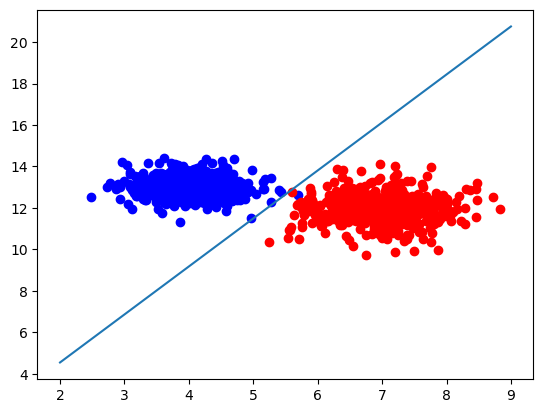

In [128]:
decicion_boundary_x_s = np.linspace(2, 9, 1000)
decicion_boundary_y_s = my_regression.decicion_boundary_2params(decicion_boundary_x_s)

# нарисуем границу принятия решения
plt.scatter(blue_class_X, blue_class_Y, c='blue')
plt.scatter(red_class_X, red_class_Y, c='red')
plt.plot(decicion_boundary_x_s, decicion_boundary_y_s)

In [129]:
# сравним с logistic regression из sklearn
sklearn_log_reg = LogisticRegression()
sklearn_log_reg.fit(np.asarray(X), Y)
sklearn_predictions = sklearn_log_reg.predict(np.asarray(X_test))
sklearn_score = accuracy_score(Y_test, sklearn_predictions)

print('sklearn score is {0}'.format(sklearn_score))
print('my model score is {0}'.format(my_score))

sklearn score is 0.9974
my model score is 0.99705
